# Статистика, DS-поток
## Задание SP.7

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.


**Баллы за задание:**

* Задача 1 &mdash; 40 баллов;
* Задача 2 &mdash; 30 баллов;
* Задача 3 &mdash; 30 баллов;
* Задача 4 &mdash; 30 баллов;
* Задача 5 &mdash; 60 баллов.

**Важность задач:**

* *высокая:* задачи 1, 5;
* *средняя:* задача 3, 4;
* *обычная:* задача 2.

In [1]:
# Bot check

# HW_ID: ds_sp7
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [52]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

from sklearn.datasets import fetch_california_housing

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from statsmodels.nonparametric.kde import KDEUnivariate

___
### Задача 1.

Для данных из задачи ML.5.2 рассмотрим две модели: случайный лес и ридж-регрессия. Постройте бутстрепные доверительные интервалы трех типов для метрик MSE, MAE, MAPE этих двух моделей.

**Решение:**

In [2]:
def construct_empirical(sample):
    values, counts = np.unique(sample, return_counts=True)
    return sps.rv_discrete(name='empirical', values=(values, counts / sample.shape))

In [3]:
dataset = fetch_california_housing()

In [22]:
from math import ceil, floor

def bootstrap_interval(sample, estimator, method, b=100, alpha=0.95):
    est = estimator(sample)
    distr = construct_empirical(sample)
    if method == 'normal':
        boot_var = np.var(estimator(distr.rvs(size=(b, sample.shape[0])), axis=-1))
        return (est - sps.norm.ppf((1 + alpha) / 2) * np.sqrt(boot_var), est + sps.norm.ppf((1 + alpha) / 2) * np.sqrt(boot_var))
    boot_est = np.sort(estimator(distr.rvs(size=(b, sample.shape[0])), axis=-1))
    if method == 'central':
        return (2 * est - boot_est[ceil(b * (1 + alpha) / 2) - 1], 2 * est - boot_est[floor(b * (1 - alpha) / 2) - 1])
    if method == 'quantile':
        return (boot_est[floor(b * (1 - alpha) / 2) - 1], boot_est[ceil(b * (1 + alpha) / 2) - 1])
    raise ValueError("method not in ['normal', 'central', 'quantile']")

In [5]:
def mse(diff, axis=-1):
    return np.mean(diff**2, axis=axis)


def mae(diff, axis=-1):
    return np.mean(np.abs(diff), axis=axis)


def mape(frac, axis=-1):
    return np.mean(np.abs(frac), axis=axis)

In [23]:
X, y = dataset.data, dataset.target

forest_model = RandomForestRegressor(n_jobs=-1)
forest_model.fit(X, y)

diff = forest_model.predict(X) - y
frac = diff / y

In [8]:
print('=== Нормальные интервалы ===')
print('MSE: (%.3f; %.3f)' % bootstrap_interval(diff, mse, method='normal', b=10))
print('MAE: (%.3f; %.3f)' % bootstrap_interval(diff, mae, method='normal', b=10))
print('MAPE: (%.3f; %.3f)' % bootstrap_interval(frac, mape, method='normal', b=10))

=== Нормальные интервалы ===
MSE: (0.033; 0.035)
MAE: (0.116; 0.122)
MAPE: (0.065; 0.069)


In [25]:
print('=== Центральные интервалы ===')
print('MSE: (%.6f; %.6f)' % bootstrap_interval(diff, mse, method='central', b=10))
print('MAE: (%.6f; %.6f)' % bootstrap_interval(diff, mae, method='central', b=10))
print('MAPE: (%.6f; %.6f)' % bootstrap_interval(frac, mape, method='central', b=10))

=== Центральные интервалы ===
MSE: (0.034152; 0.034152)
MAE: (0.117684; 0.117684)
MAPE: (0.066048; 0.066048)


In [26]:
print('=== Квантильные интервалы ===')
print('MSE: (%.6f; %.6f)' % bootstrap_interval(diff, mse, method='quantile', b=10))
print('MAE: (%.6f; %.6f)' % bootstrap_interval(diff, mae, method='quantile', b=10))
print('MAPE: (%.6f; %.6f)' % bootstrap_interval(frac, mape, method='quantile', b=10))

=== Квантильные интервалы ===
MSE: (0.035028; 0.035028)
MAE: (0.121795; 0.121795)
MAPE: (0.068111; 0.068111)


In [27]:
ridge_model = Ridge()
ridge_model.fit(X, y)

diff = ridge_model.predict(X) - y
frac = diff / y

In [16]:
print('=== Нормальные интервалы ===')
print('MSE: (%.3f; %.3f)' % bootstrap_interval(diff, mse, method='normal', b=10))
print('MAE: (%.3f; %.3f)' % bootstrap_interval(diff, mae, method='normal', b=10))
print('MAPE: (%.3f; %.3f)' % bootstrap_interval(frac, mape, method='normal', b=10))

=== Нормальные интервалы ===
MSE: (0.514; 0.535)
MAE: (0.526; 0.536)
MAPE: (0.314; 0.320)


In [28]:
print('=== Центральные интервалы ===')
print('MSE: (%.6f; %.6f)' % bootstrap_interval(diff, mse, method='central', b=10))
print('MAE: (%.6f; %.6f)' % bootstrap_interval(diff, mae, method='central', b=10))
print('MAPE: (%.6f; %.6f)' % bootstrap_interval(frac, mape, method='central', b=10))

=== Центральные интервалы ===
MSE: (0.506866; 0.506866)
MAE: (0.521884; 0.521884)
MAPE: (0.312794; 0.312794)


In [29]:
print('=== Квантильные интервалы ===')
print('MSE: (%.6f; %.6f)' % bootstrap_interval(diff, mse, method='quantile', b=10))
print('MAE: (%.6f; %.6f)' % bootstrap_interval(diff, mae, method='quantile', b=10))
print('MAPE: (%.6f; %.6f)' % bootstrap_interval(frac, mape, method='quantile', b=10))

=== Квантильные интервалы ===
MSE: (0.539918; 0.539918)
MAE: (0.536461; 0.536461)
MAPE: (0.319039; 0.319039)


**Вывод:** Центральные и квантильные интервалы оказываются настолько узкими, что расстояние между границами не превосходит $10^{-6}$. Нормальные же интервалы оказываются намного шире при том же уровне доверия.

___
### Задача 2.

**1.** Сгенерируйте выборку $X_1, ..., X_{10000}$ из стандартного нормального распределения. Для каждого $n \leqslant 10000$ постройте эмпирическую функцию распределения $\widehat{F}_n$ и посчитайте **точное** значение статистики 

$$D_n = \sup\limits_{x \in \mathbb{R}} \left| \widehat{F}_n(x) - F(x) \right|.$$

Обоснуйте, почему при вашей реализации подсчета статистики полученное значение будет **точным**.

Постройте график зависимости статистики $D_n$ от $n$. Верно ли, что $D_n \to 0$ и в каком смысле?


Для выполнения задания можно использовать `statsmodels.distributions.empirical_distribution.ECDF`.

In [44]:
X = sps.norm.rvs(size=10000)

D = []

for k in range(10000):
    Xk = X[:(k + 1)]
    Fk = sps.ecdf(Xk).cdf.evaluate
    D.append(np.max(np.abs(Fk(Xk) - sps.norm.cdf(Xk))))

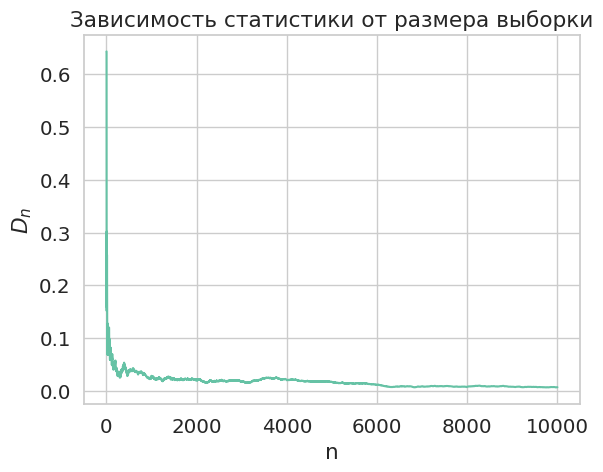

In [46]:
plt.plot(np.arange(1, 10001), D)
plt.xlabel('n')
plt.ylabel('$D_n$')
plt.title('Зависимость статистики от размера выборки')
plt.show()

Наш способ даёт точное значение, т.к. $\hat{F}_n(x)$ имеет скачки в точках выборки, и расстояние от линии $F(x)$ будет наибольшим именно в одной из точек скачков, т.к. в инетрвалах непрерывности функция постоянна, а значит модуль монотонно уменьшается до пересечения с графиком $F(x)$, а затем монотонно увеличивается до следующего скачка.

**Вывод:** Да, верно, что $D_n\rightarrow 0$, и это верно в поточечном смысле.

---

### Задача 3.

В этой задаче вы исследуете различные непараметрические оценки распределений.
Для этого вам выдается почти готовый код функций `draw_ecdf`, `draw_hist` и `draw_pdf`, которые используются для построения ЭФР, гистограммы и ядерной оценки плотности соответственно. В реализациях этих функция часть кода пропущена, вам нужно его дописать. Код предполагает использование реализации ядерных оценок плотности из `statsmodels`.
При желании вы можете написать аналогичный код, используя реализацию в `seaborn`.

In [47]:
def draw_ecdf(sample, grid, cdf=None):
    """
    По сетке cтроит графики эмпирической функции распределения 
    и истинной (если она задана) для всей выборки и для 1/10 ее части.
    
    Вход:
        sample: выборка
        grid: сетка
        cdf: истинная функция распределения из scipy.stats
    """
    
    plt.figure(figsize=(16, 3))
    # Выбирается размер выборки
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        # Отрисовываются точки выборки на графике    
        plt.scatter(
            sample[:size], [0] * size,
            alpha=0.4, label='sample'
        )
        
        # Если передана истинная функция распределения, 
        # отрисовывается ее график
        if cdf is not None:
            plt.plot(
                grid,
                [cdf(x) for x in grid],
                color='green', alpha=0.3, lw=2, label='true cdf'
            )
        
        # Отрисовывается эмпирическую функцию распределения
        ecdf = sps.ecdf(sample[:size]).cdf.evaluate
        plt.plot(
            grid,
            ecdf(grid),
            color='red', label='ecdf'
        )
        
        plt.legend()
        plt.grid(ls=':')
        plt.title('sample size = {}'.format(size))
    plt.show()

In [48]:
def draw_hist(sample, grid, pdf=None):
    """
    Строит гистограмму и, по сетке, график истинной плотности 
    (если она задана) для всей выборки и для 1/10 ее части.
    
    Вход:
        sample: выборка
        grid: сетка
        pdf: истинная плотность из scipy.stats
    """
    
    plt.figure(figsize=(16, 3))
    # Выбирается размер выборки
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        # Построение гистограммы для выборки
        plt.hist(
            sample[:size], 
            bins=20,
            range=(grid.min(), grid.max()),
            density=True, label='sample hist'
        )
        
        # Если передана истинная плотность, отрисовывается ее график
        if pdf is not None:
            plt.plot(
                grid,
                [pdf(x) for x in grid],
                color='green', alpha=0.3, lw=2, label='true pdf'
            )
        
        plt.legend()
    plt.show()

In [49]:
def draw_pdf(sample, grid, pdf=None):
    """
    По сетке cтроит графики ядерной оценки плотности 
    и истинной плотности (если она задана) для всей выборки 
    и для 1/10 ее части.
    
    Вход:
        sample: выборка
        grid: сетка
        pdf: истинная плотность из scipy.stats
    """
    
    plt.figure(figsize=(16, 3))
    # Выбирается размер выборки
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        # Отрисовка точек выборки на графике
        plt.scatter(
            sample[:size], [0] * size, 
            alpha=0.4, label='sample'
        )
        
        # Если передана истинная плотность, отрисовывается ее график
        if pdf is not None:
            plt.plot(
                grid,
                [pdf(x) for x in grid], 
                color='green', alpha=0.3, lw=2, label='true pdf'
            )
        
        # Отрисовывается KDE
        kde = KDEUnivariate(sample[:size])
        kde.fit()

        plt.plot(
            grid,
            kde.evaluate(grid),
            color='red', label='kde'
        )
        
        plt.legend()
        plt.grid(ls=':')
    plt.show()

Используя реализованные выше функции, постройте график эмпирической функции распределения (ЭФР), гистограмму и график ядерной оценки плотнотности к выборкам размера 500 для следующих распределений:

*1. Равномерное распределение $U[0,1]$*. Графики функции распределения и плотностей строить на интервале $(-0.2, 1.2)$.

In [59]:
def draw_plots(model, xmin, xmax, size=500):
    sample = model.rvs(size=size)
    grid = np.linspace(xmin, xmax, 1000)
    draw_ecdf(sample, grid=grid, cdf=model.cdf)
    draw_hist(sample, grid=grid, pdf=model.pdf)
    draw_pdf(sample, grid=grid, pdf=model.pdf)

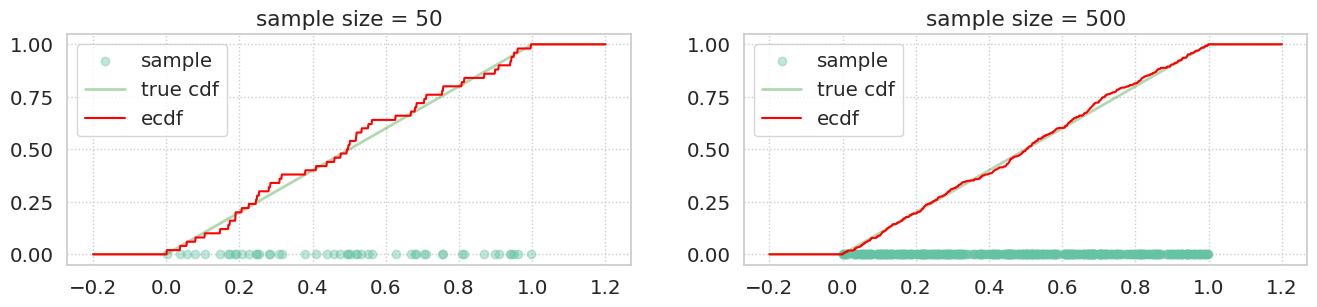

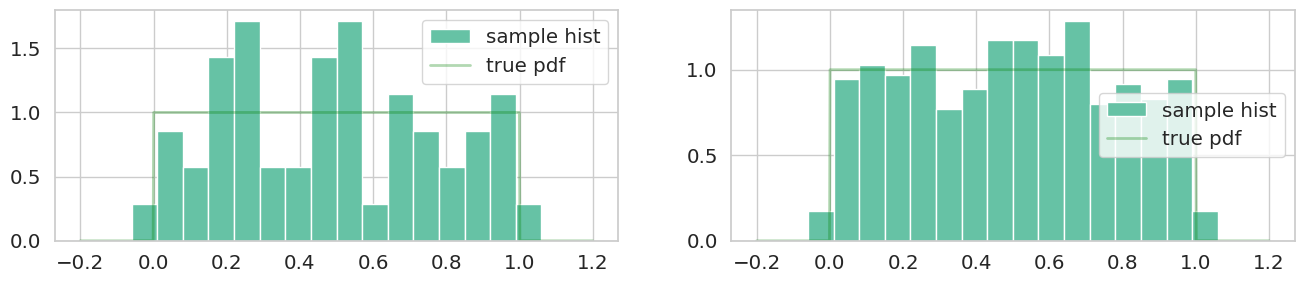

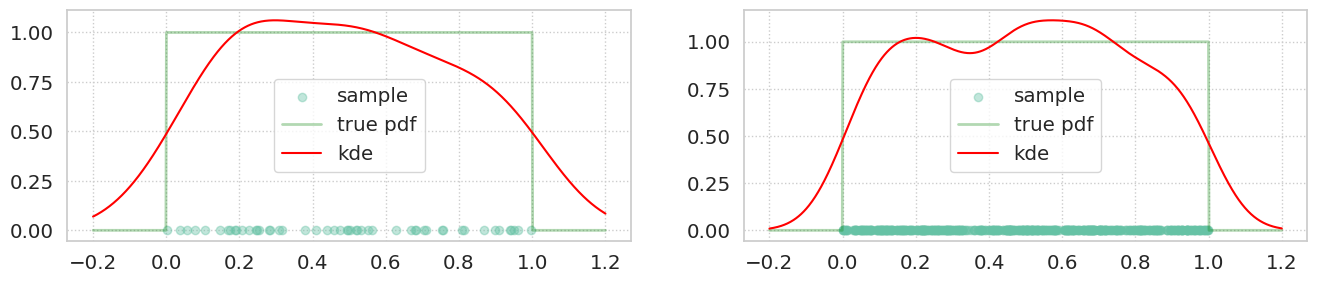

In [57]:
draw_plots(sps.uniform, -0.2, 1.2)

*2. Нормальное распределение $\mathcal{N}(0, 1)$.* Графики функции распределения и плотностей строить на интервале $(-3, 3)$.

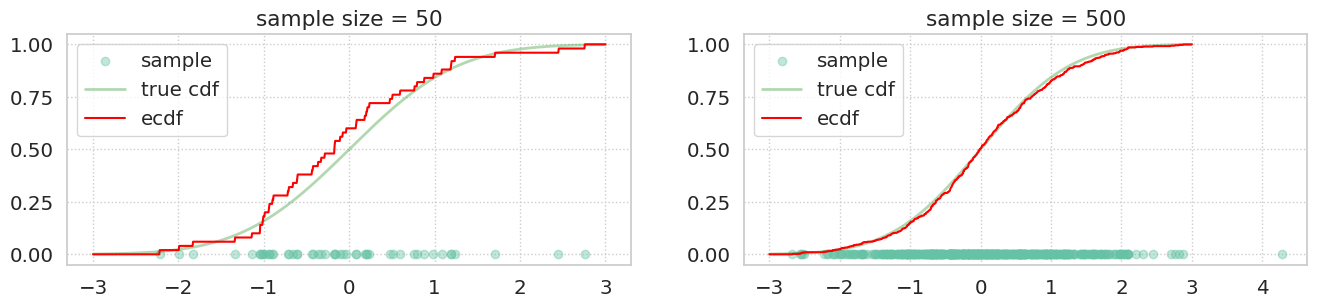

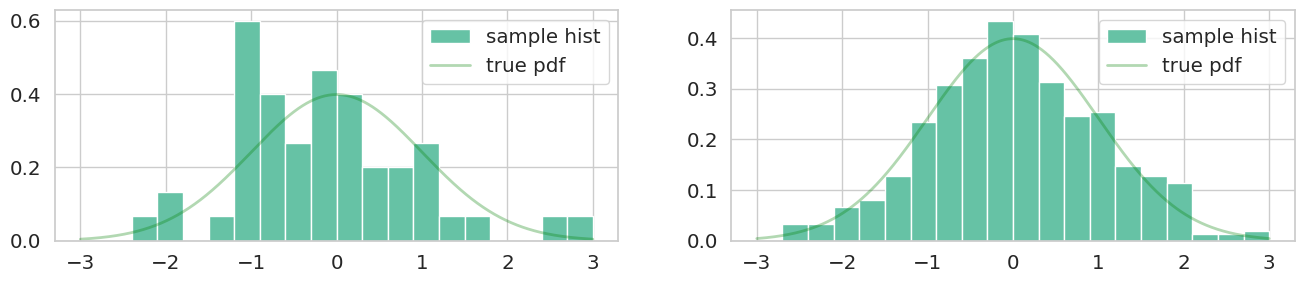

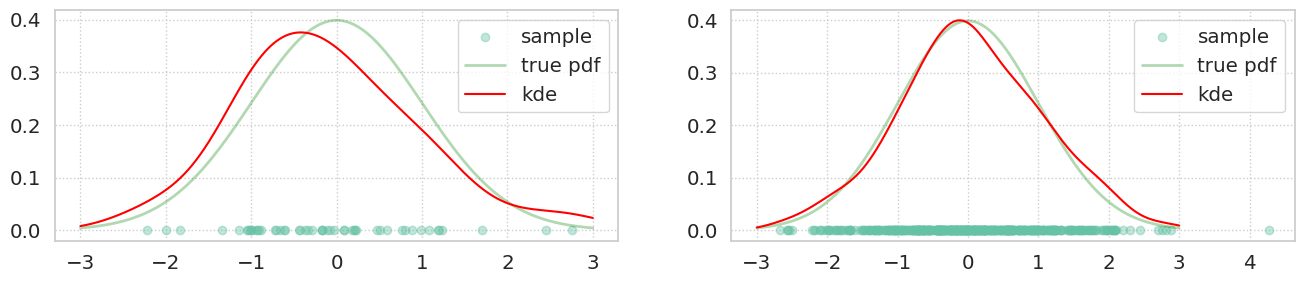

In [60]:
draw_plots(sps.norm, -3, 3)

*3. Экспоненциальное распределение $Exp(1)$.* Графики функции распределения и плотностей  строить на интервале $(-0.5, 5)$.

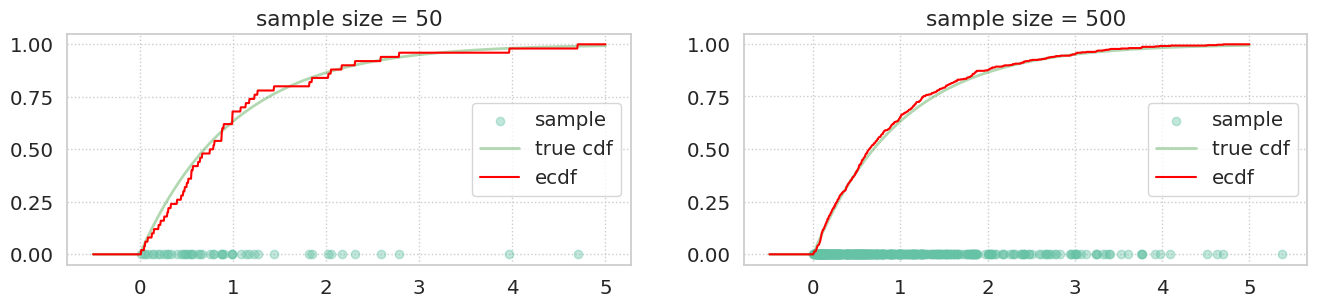

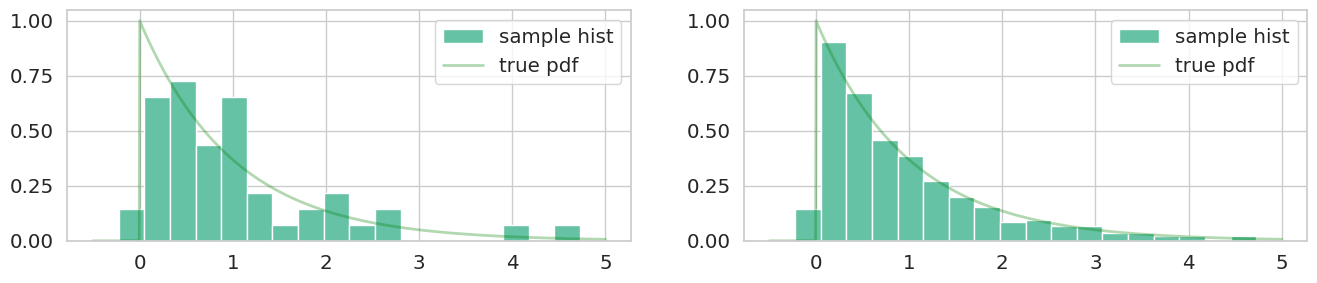

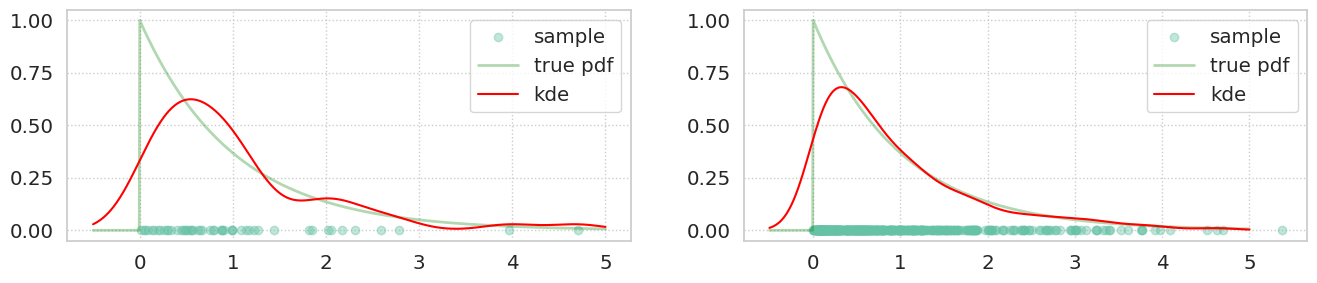

In [61]:
draw_plots(sps.expon, -0.5, 5)

Опишите полученные результаты, сравните их между выборками из различных распределений.

**Вывод:**

Чем больше выборка, тем ближе эмпирическое распределение к настоящему. Ядерные оценки плотность хорошо приближают настоящую плотность распределения при достаточно большом размере выборки, если плотность непрерывна (как в случае нормального распределения). Однако, вблизи точек разрыва настоящей функции плотности ядерная оценка оказывается далека от истины, что связано с тем, что ядерная оценка строится как непрерывная функция (данная проблема схожа с явлением Гиббса при разложении в ряд Фурье вблизи точек разрыва).

---
### Задача 4.

Исследуйте вид ядерной оценки плотности в зависимости от вида ядра и его ширины.

Для этого сгенерируйте выборку $X_1, ..., X_{200}$ из распределения $U[0, 1]$ и постройте серию графиков для различной ширины гауссовского ядра, а затем другую серию графиков для различных типов ядер при фиксированной ширине. На каждом графике на отрезке $[-0.2, 1.2]$ должны быть изображены истинная плотность (полупрозрачным цветом) и ее ядерная оценка, а так же с нулевой $y$-координатой должны быть нанесены точки выборки. Для экономии места стройте графики в два столбца.

Вам выдется почти готовый код для выполнения задания с некоторыми пропусками. Код предполагает использование реализации ядерных оценок плотности из `statsmodels`. При желании вы можете написать аналогичный код, используя реализацию в `seaborn`. При построении KDE разрешается использовать цикл.

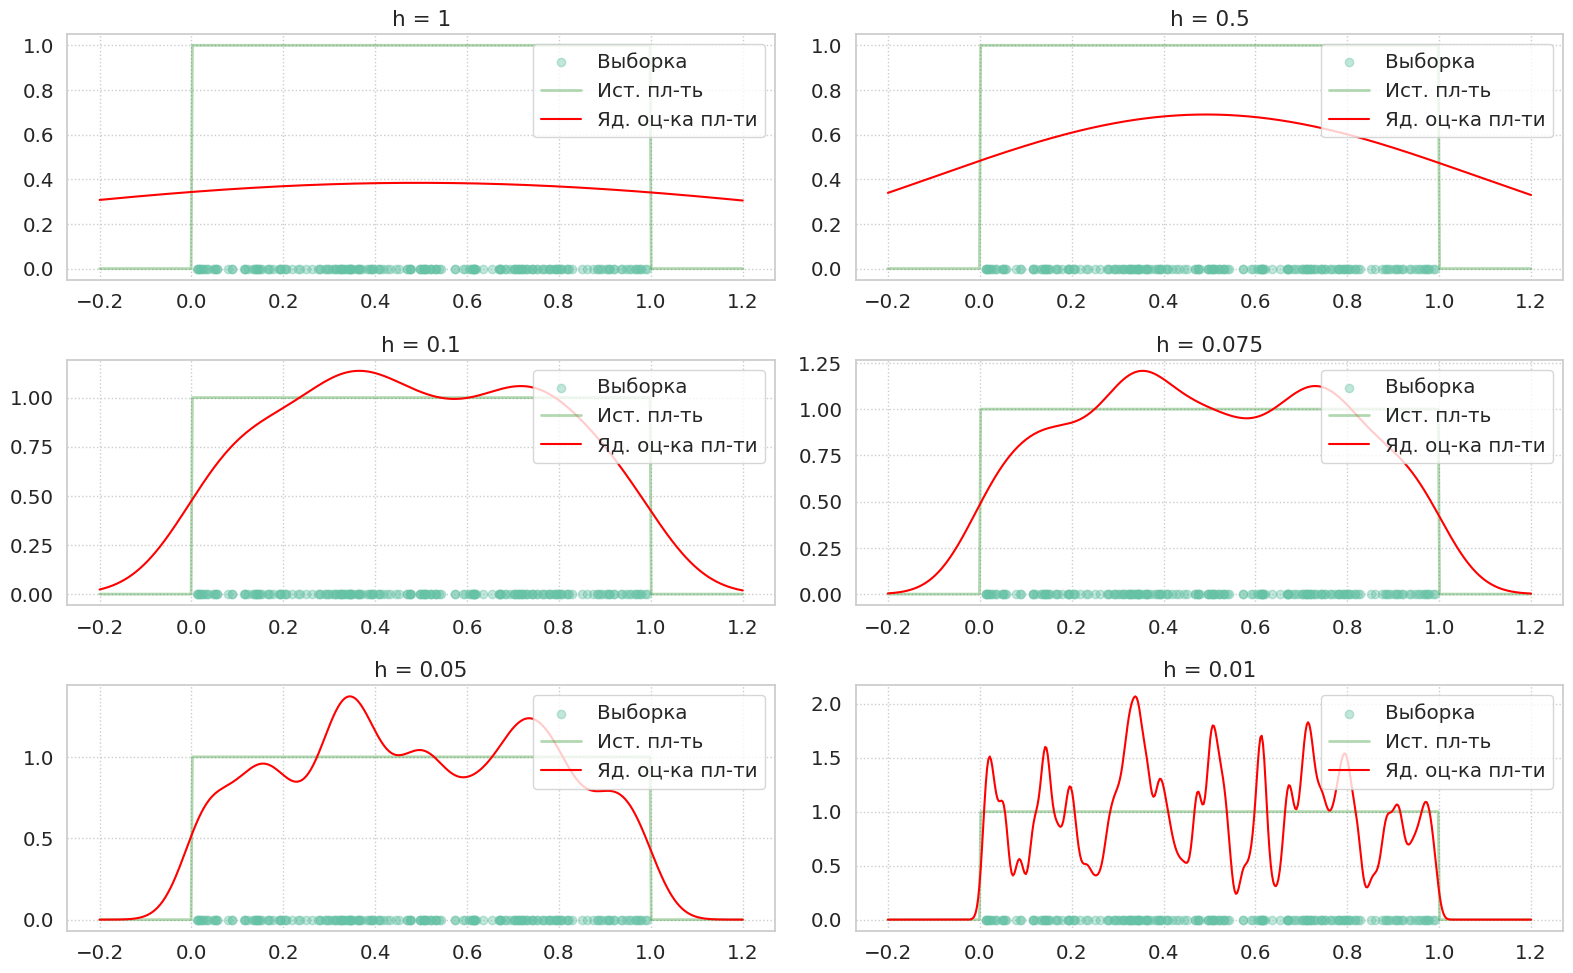

In [66]:
# Размер выборки
size = 200
# Выборка размера size
sample = sps.uniform.rvs(size=size)
# Сетка на отрезке из условия
grid = np.linspace(-0.2, 1.2, 500)

plt.figure(figsize=(16, 10))

# Итераций по ширине ядра
for i, bw in enumerate([1, 0.5, 0.1, 0.075, 0.05, 0.01]):
    plt.subplot(3, 2, i + 1)
    # Построение KDE
    kernel_density = KDEUnivariate(sample)
    kernel_density.fit(bw=bw)
    # Отображение элементов выборки
    plt.scatter(sample, np.zeros(size), alpha=0.4, label='Выборка')
    # Построение истинной плотности выборки
    plt.plot(grid, sps.uniform.pdf(grid), color='green', 
             alpha=0.3, lw=2, label='Ист. пл-ть')
    # Отображение KDE плотности
    plt.plot(grid, kernel_density.evaluate(grid), 
             color='red', label='Яд. оц-ка пл-ти')
    plt.legend(loc=1)
    plt.grid(ls=':')
    plt.title('h = {}'.format(bw))
plt.tight_layout()
plt.show()

Во втором случае графики постройте аналогичным образом, проведя итерации по типу ядра.

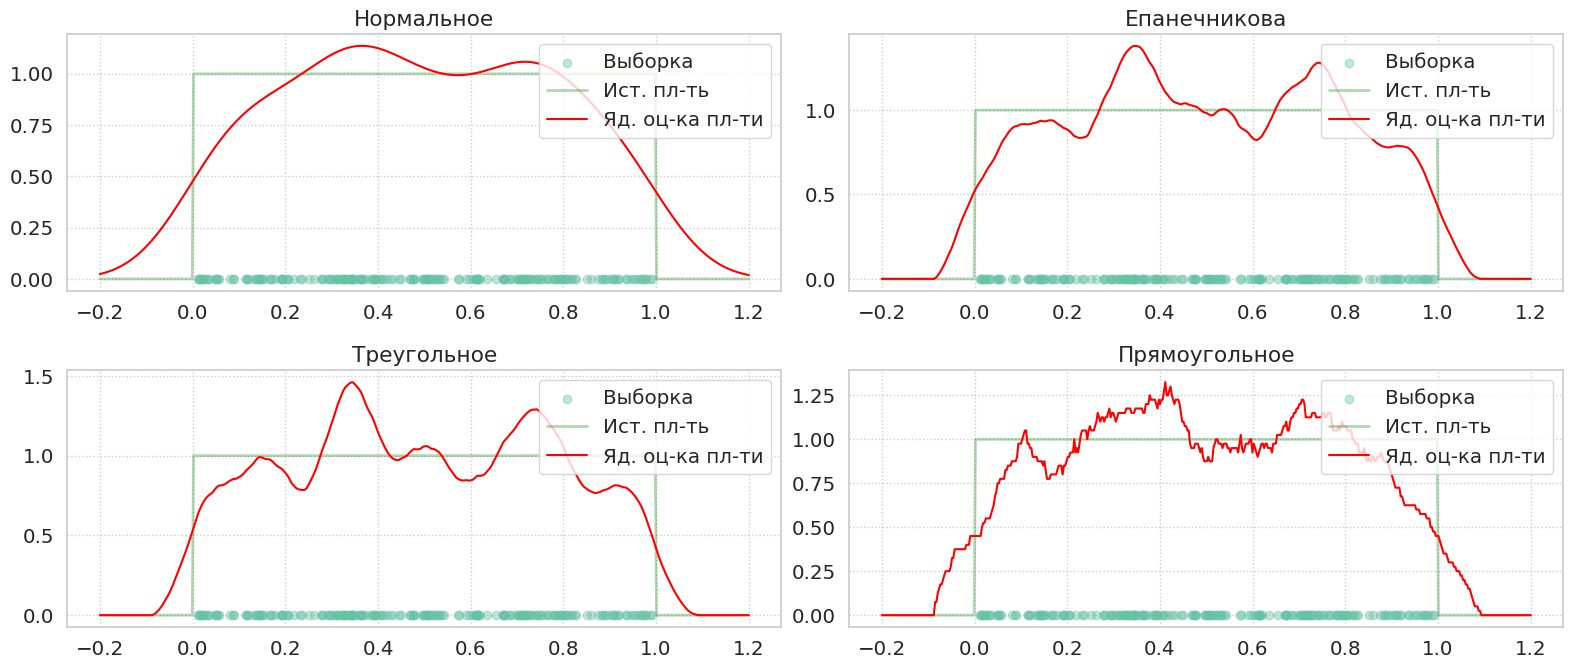

In [102]:
from math import isnan
from warnings import filterwarnings
filterwarnings('ignore')

plt.figure(figsize=(16, 10))

kernel_names = {
    'gau': 'Нормальное',
    'epa': 'Епанечникова',
    'tri': 'Треугольное',
    'uni': 'Прямоугольное'
}

# Итераций по ширине ядра
for i, kernel in enumerate(['gau', 'epa', 'tri', 'uni']):
    plt.subplot(3, 2, i + 1)
    # Построение KDE
    kernel_density = KDEUnivariate(sample)
    kernel_density.fit(kernel=kernel, fft=False, bw=0.1)
    # Отображение элементов выборки
    plt.scatter(sample, np.zeros(size), alpha=0.4, label='Выборка')
    # Построение истинной плотности выборки
    plt.plot(grid, sps.uniform.pdf(grid), color='green', 
             alpha=0.3, lw=2, label='Ист. пл-ть')
    # Отображение KDE плотности
    # Так как при наличии хотя бы одного значения вне некоторого диапазона
    # evaluate выдаёт единственное значение nan на всю сетку,
    # вынуждены считать в цикле, приводя nan к 0
    kde_est = []
    for i, x in enumerate(grid):
        kde_est.append(kernel_density.evaluate(x)[0] if not isnan(kernel_density.evaluate(x)) else 0)
    plt.plot(grid, kde_est, 
             color='red', label='Яд. оц-ка пл-ти')
    plt.legend(loc=1)
    plt.grid(ls=':')
    plt.title('{}'.format(kernel_names[kernel]))
plt.tight_layout()
plt.show()

**Вывод:**

Различные ядра справляются с оценкой плотности примерно одинаково. До $h=0.1$ уменьшение ширины ядра повышает точность, далее оценка плотности начинает быстро скакать между значениями. Причиной такого поведения является то, что при очень малой ширине носители ядер, соответствующих разным значениям в выборке, пересекаются мало. Также у всех ядер наблюдается эффект, упомянутый в прошлом задании - большая ошибка вблизи точек разрыва, но с уменьшением ширины ядра область большой ошибки сокращается.

---
### Задача 5.

Рассмотрим задачу регрессии. Мы уже научились оценивать зависимость $y(x)$, но это только точечная оценка для каждого конкретного $x$. На практике бывает необходимо строить доверительные интервалы, которые в совокупности образуют доверительные ленты. Поскольку мы ничего не знаем про распределение ошибок, будем строить доверительную ленту по методу бутстрепа.

1. Сгенерируем достаточно большое число бутстрепных выборок.

2. Обучим модели и получим значения $\widehat{y}(x)$, для всех значений $x$ по сетке значений.

3. По предсказаным значениям оценим верхнюю и нижнюю границы ленты с помощью методов построения бутстрепных доверительных интервалов.

Напишите функцию, которая реализует данный метод

In [137]:
def bootstrap_confidence_interval(
    X, Y, model, X_grid, bootstrap_count=10, alpha=0.95, model_args={}
):
    '''
    Построение предсказательной ленты для модели регрессии.
    
    X, Y - выборка;
    model - класс модели;
    X_grid - сетка для доверительной ленты;
    alpha - уровень доверия;
    bootstrap_count - количество бутстрепных выборок
    model_args - параметры модели.
    '''
    
    predictions = []

    for _ in tqdm(np.arange(bootstrap_count)):
        bootstrap_model = model(**model_args)
        bootstrap_sample = np.random.choice(np.arange(len(X)), size=len(X), replace=True)
        bootstrap_model.fit(X[bootstrap_sample].reshape(-1, 1), Y[bootstrap_sample])
        predictions.append(bootstrap_model.predict(X_grid.reshape(-1, 1)))

    boot_est = np.mean(predictions, axis=0)
    boot_var = np.var(predictions, axis=0)
    lower_bound = boot_est - sps.norm.ppf((1 + alpha) / 2) * np.sqrt(boot_var)
    upper_bound = boot_est + sps.norm.ppf((1 + alpha) / 2) * np.sqrt(boot_var)
    return lower_bound, upper_bound

Рассмотрим датасет cps71 из семинара

In [156]:
data = pd.read_csv('cps71.csv', index_col=0)

X = data['age']
y = data['logwage']
data.head()

,logwage,age
1,11.1563,21
2,12.8131,22
3,13.0960,22
4,11.6952,22
5,11.5327,22


Разделим нашу выборку на обучающую и тестовую

In [157]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [158]:
x_grid = np.linspace(np.min(X), np.max(X), 1000)

Постройте доверительные ленты для моделей линейной регрессии, ядерной регрессии и KNN-регрессии.
Изобразите на графике также предсказания каждой модели и обучающую выборку.

*Примечание: для классов из statmodels сигнатура класса может не совпадать со стандартной, поэтому сделайте для этих классов, класс-обертку, который в себе просто будет вызывать нужные методы.*

  0%|          | 0/10 [00:00<?, ?it/s]

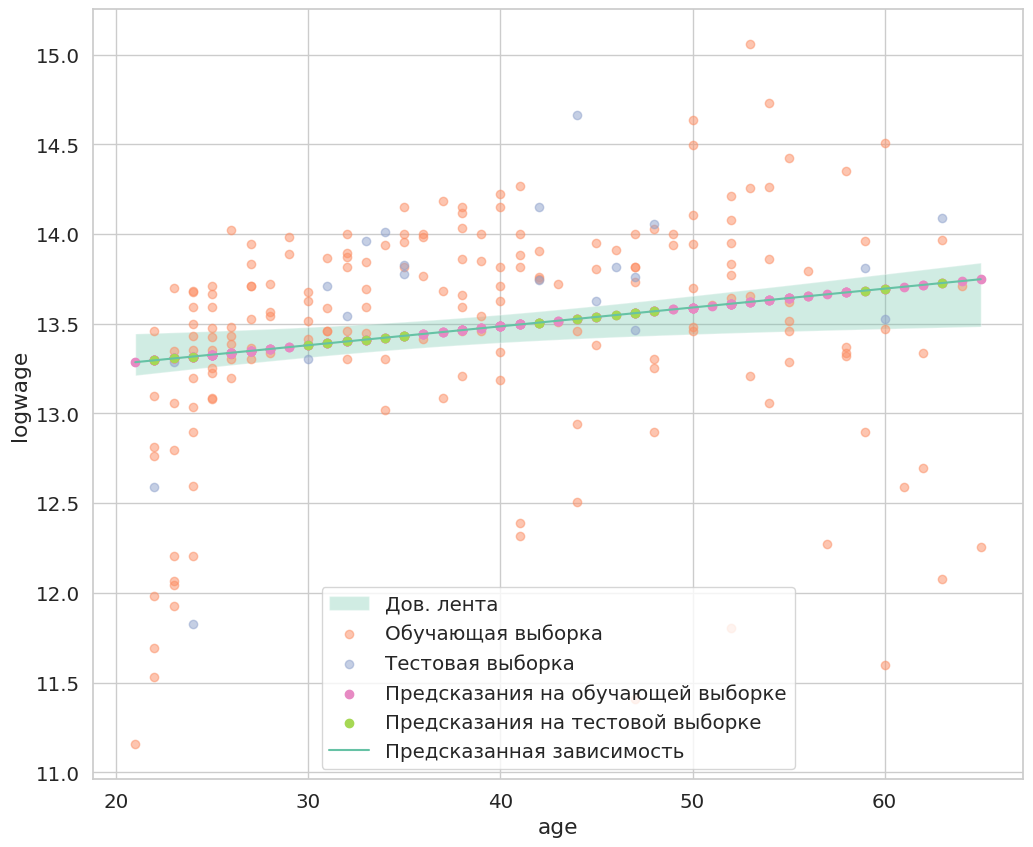

In [178]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_train.values.reshape(-1, 1), y_train)
y_test_pred = model.predict(X_test.values.reshape(-1, 1))
y_train_pred = model.predict(X_train.values.reshape(-1, 1))
y_pred_func = model.predict(x_grid.reshape(-1, 1))

lower_bound, upper_bound = bootstrap_confidence_interval(X_train.values, y_train.values, LinearRegression, x_grid)

plt.figure(figsize=(12, 10))
plt.fill_between(x_grid, lower_bound, upper_bound, alpha=0.3, label='Дов. лента')
plt.scatter(X_train, y_train, alpha=0.5, label='Обучающая выборка')
plt.scatter(X_test, y_test, alpha=0.5, label='Тестовая выборка')
plt.scatter(X_train, y_train_pred, label='Предсказания на обучающей выборке')
plt.scatter(X_test, y_test_pred, label='Предсказания на тестовой выборке')
plt.plot(x_grid, y_pred_func, label='Предсказанная зависимость')
plt.xlabel('age')
plt.ylabel('logwage')
plt.legend()
plt.show()

In [173]:
from statsmodels.nonparametric.kernel_regression import KernelReg
import sklearn.base

class KernelRegression(sklearn.base.RegressorMixin):
    def __init__(self, predict_grid, var_type='c', **kwargs):
        self.predict_grid = predict_grid
        self.var_type = var_type
        self.reg_params = kwargs
    
    def fit(self, X, y=None):
        model = KernelReg(exog=X, endog=y, var_type=self.var_type, **self.reg_params)
        self.predictions = model.fit(self.predict_grid)[0]
        return self
    
    def predict(self, X):
        diffs = np.abs(self.predict_grid.reshape(-1, 1) - X.reshape(1, -1))
        idx = np.argmin(diffs, axis=0)
        return self.predictions[idx]

  0%|          | 0/10 [00:00<?, ?it/s]

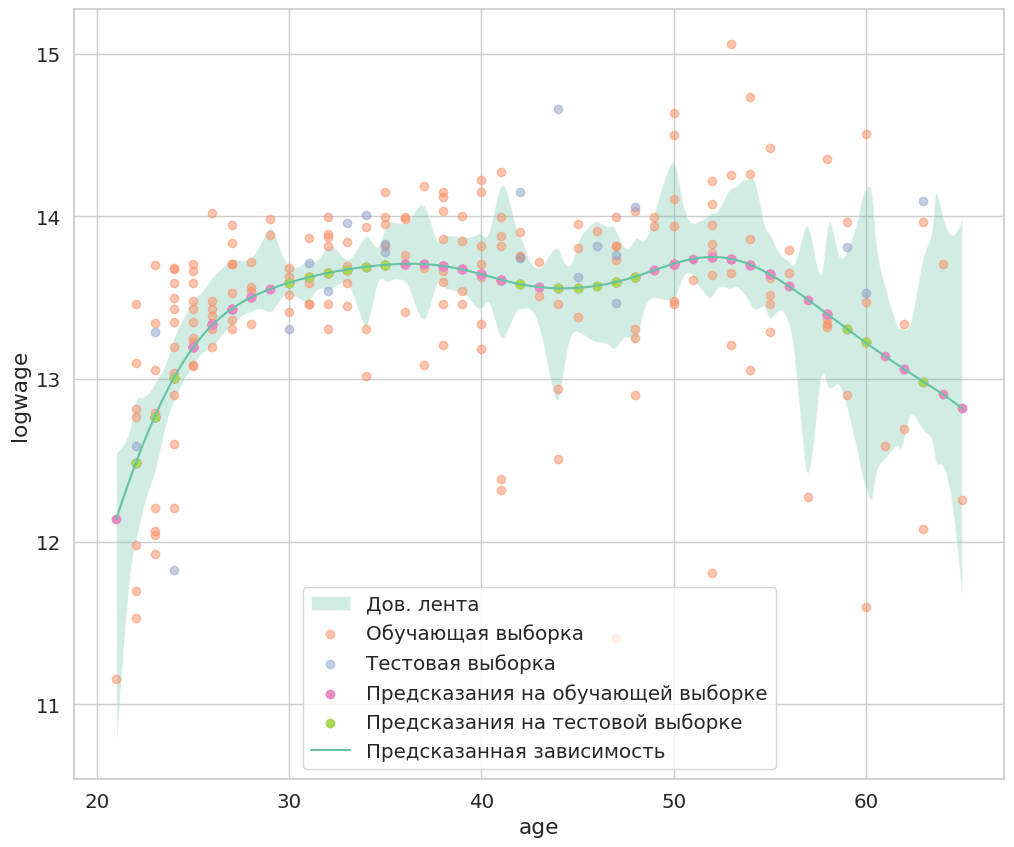

In [180]:
lower_bound, upper_bound = bootstrap_confidence_interval(X_train.values, y_train.values, KernelRegression, x_grid, model_args={'predict_grid': x_grid})

model = KernelRegression(x_grid).fit(X_train.values.reshape(-1, 1), y_train)
y_test_pred = model.predict(X_test.values.reshape(-1, 1))
y_train_pred = model.predict(X_train.values.reshape(-1, 1))
y_pred_func = model.predict(x_grid.reshape(-1, 1))

plt.figure(figsize=(12, 10))
plt.fill_between(x_grid, lower_bound, upper_bound, alpha=0.3, label='Дов. лента')
plt.scatter(X_train, y_train, alpha=0.5, label='Обучающая выборка')
plt.scatter(X_test, y_test, alpha=0.5, label='Тестовая выборка')
plt.scatter(X_train, y_train_pred, label='Предсказания на обучающей выборке')
plt.scatter(X_test, y_test_pred, label='Предсказания на тестовой выборке')
plt.plot(x_grid, y_pred_func, label='Предсказанная зависимость')
plt.xlabel('age')
plt.ylabel('logwage')
plt.legend()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

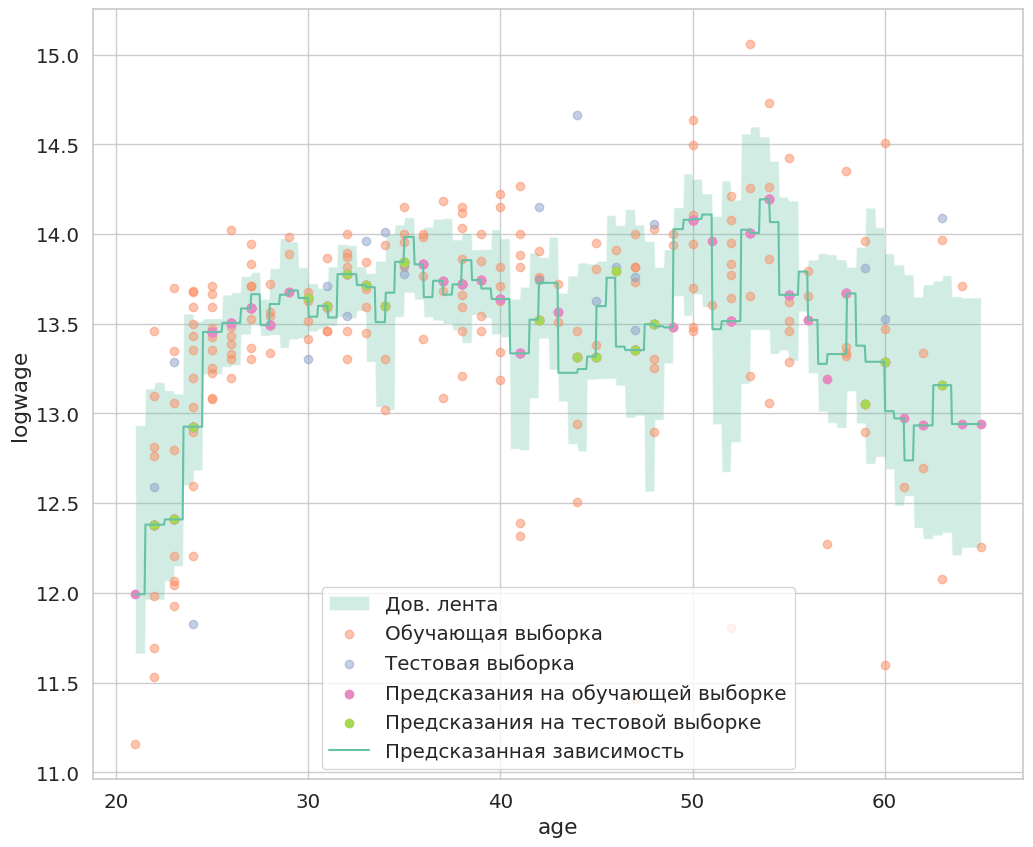

In [181]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor().fit(X_train.values.reshape(-1, 1), y_train)
y_test_pred = model.predict(X_test.values.reshape(-1, 1))
y_train_pred = model.predict(X_train.values.reshape(-1, 1))
y_pred_func = model.predict(x_grid.reshape(-1, 1))

lower_bound, upper_bound = bootstrap_confidence_interval(X_train.values, y_train.values, KNeighborsRegressor, x_grid)

plt.figure(figsize=(12, 10))
plt.fill_between(x_grid, lower_bound, upper_bound, alpha=0.3, label='Дов. лента')
plt.scatter(X_train, y_train, alpha=0.5, label='Обучающая выборка')
plt.scatter(X_test, y_test, alpha=0.5, label='Тестовая выборка')
plt.scatter(X_train, y_train_pred, label='Предсказания на обучающей выборке')
plt.scatter(X_test, y_test_pred, label='Предсказания на тестовой выборке')
plt.plot(x_grid, y_pred_func, label='Предсказанная зависимость')
plt.xlabel('age')
plt.ylabel('logwage')
plt.legend()
plt.show()

Сделайте выводы

**Вывод:**

В данном случае все модели с точки зрения построения зависимости справились достаточно плохо, что связано с тем, что одному `age` соответствует несколько `logwage`. Однако, если судить по доверительной ленте, модели ядерной регрессии и KNN справились намного лучше линейной регрессии, построив области, в которые действительно попадает значительная доля точек датасета.